# Time Series Analysis
**Short-term temperature forecoast**

- understand the purpose of Time Series Analysis
- understand the concept of **time dependence** in time series data
- understand how to use AR and ARIMA models in order to predict the future

Checklist
- read a temperature curve
- decompose the time series
- train a linear model
- try other forecasting methods
- calculate quality metrics
- download more data
- plot climate data on a map

## 1. Download and read the data

- Go to www.ecad.eu
- Go to “Daily data”
- Click on “Custom query (ASCII)”
- Pick:
    - Type of series: blend
    - Country: Germany
    - Location: Berlin-Tempelhof
    - Element: Mean temperature


- read the data into a dataframe

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/ECA_blended_custom/TG_STAID002759_descr_removed.txt') # , header=0, sep=',', quotechar='"'
df.head(150)

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0
...,...,...,...,...
145,127488,18760525,148,0
146,127488,18760526,119,0
147,127488,18760527,94,0
148,127488,18760528,115,0


In [3]:
df.info() # whitespaces in column names

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52808 entries, 0 to 52807
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0    SOUID    52808 non-null  int64
 1       DATE  52808 non-null  int64
 2      TG     52808 non-null  int64
 3    Q_TG     52808 non-null  int64
dtypes: int64(4)
memory usage: 1.6 MB


In [4]:
df.loc[0]

 SOUID        127488
    DATE    18760101
   TG             22
 Q_TG              0
Name: 0, dtype: int64

In [5]:
# remove whitespaces in df
df = df.rename(columns=lambda x: x.strip())

In [6]:
df.loc[0]

SOUID      127488
DATE     18760101
TG             22
Q_TG            0
Name: 0, dtype: int64

#### temperature (TG) is in unit of the temperature is 0.1 °C (multiplied by 10)
so that all values are integers (was important back than to save expensive data storage cost)

In [7]:
# convert the temperature into unit of 1°C 
df['TG'] = df['TG']/10
df.head()

,SOUID,DATE,TG,Q_TG
0,127488,18760101,2.2,0
1,127488,18760102,2.5,0
2,127488,18760103,0.3,0
3,127488,18760104,-5.8,0
4,127488,18760105,-9.8,0


**The temperature T in Kelvin (K) is equal to the temperature T in degrees Celsius (°C) plus 273.15:**

$T(K) = T(°C) + 273.15$

In [8]:
# convert the temperature into Kelvin 
# (because otherwise it will through an error calculating the percentage change (must be positive))
df['TG'] = df['TG'] + 273.15
df.head()

,SOUID,DATE,TG,Q_TG
0,127488,18760101,275.35,0
1,127488,18760102,275.65,0
2,127488,18760103,273.45,0
3,127488,18760104,267.35,0
4,127488,18760105,263.35,0


### Format the date column to datetime 
How to calculate with timestamps?
- 1st Jan 1970 is the zero timestamp (when the first Linux System was launched?)
- pandas is using integers for the timestamps internally

In [9]:
# format "DATE" column to datetime and set it as index 
df.set_index(pd.to_datetime(df['DATE'], format='%Y%m%d'), inplace=True)
# drop DATE column, SOUID and Q_TG column (contains only 0's)
df = df.drop(['DATE', 'SOUID', 'Q_TG'], axis=1)
df.head()

,TG
DATE,
1876-01-01,275.35
1876-01-02,275.65
1876-01-03,273.45
1876-01-04,267.35
1876-01-05,263.35


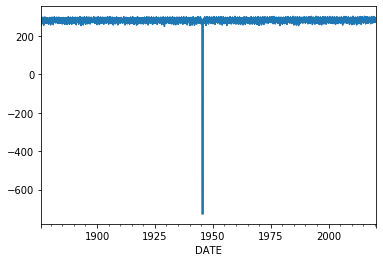

In [10]:
# plot the raw temperature data
df['TG'].plot()

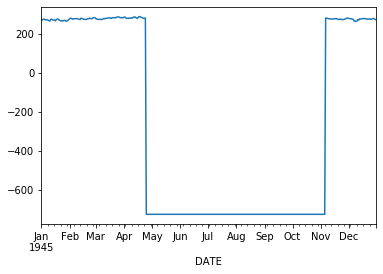

In [11]:
# zoom in the outlier area:
df.loc['1945-01-01':'1945-12-31', 'TG'].plot() # may to november 1945 the same value

### Day-dependent interpolation
- to fill the missing values (-9999 (-999.9 in C, -726.75 in K) was used as NaN values)

In [16]:
df_year_1945 = df.loc['1945-01-01':'1945-12-31']
df_year_1944 = df.loc['1944-01-01':'1944-12-31']
df_year_1946 = df.loc['1946-01-01':'1946-12-31']

for row in df_year_1945.itertuples():
    temp = row[1]
    if temp == -726.75:
        temp_44 = df_year_1944.at[(row.Index - pd.DateOffset(years=1), 'TG')]
        temp_46 = df_year_1946.at[(row.Index + pd.DateOffset(years=1), 'TG')]
        mean = (temp_44 + temp_46) / 2
        df.at[row.Index, 'TG'] = mean

print(df.loc['1945-04-25':'1945-05-15'])

                TG
DATE              
1945-04-25  284.65
1945-04-26  286.55
1945-04-27  285.45
1945-04-28  284.30
1945-04-29  283.25
1945-04-30  284.45
1945-05-01  286.75
1945-05-02  287.20
1945-05-03  283.65
1945-05-04  283.45
1945-05-05  283.50
1945-05-06  284.15
1945-05-07  284.05
1945-05-08  282.60
1945-05-09  283.60
1945-05-10  286.00
1945-05-11  286.65
1945-05-12  288.65
1945-05-13  291.00
1945-05-14  289.20
1945-05-15  281.15


In [17]:
# other solution specific to the subset of missing values:
# df2 = df[df["TG"] == -9999]
# df2["TG"] = (df["1944-04-25" : "1944-11-05"]["TG"].array + df["1946-04-25" : "1946-11-05"]["TG"].array)/2
# df[df["TG"] == -9999] = df2

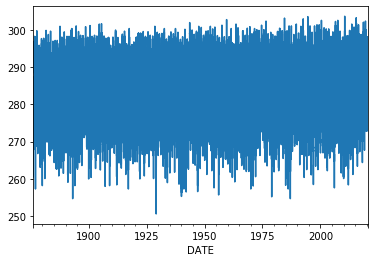

In [18]:
df['TG'].plot()

In [19]:
df.head()

,TG
DATE,
1876-01-01,275.35
1876-01-02,275.65
1876-01-03,273.45
1876-01-04,267.35
1876-01-05,263.35


In [20]:
# write cleaned data to csv
df.to_csv('data/temp_data_cleaned.csv', index=True)

### Look at subsets of the data to be able to detect trend, seasonality 

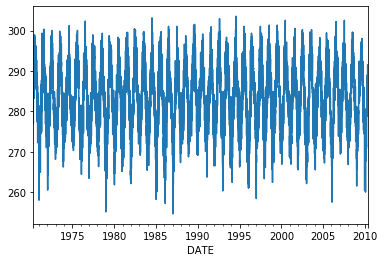

In [36]:
plot_df = df.loc['1970-04-25':'2010-05-15']
plot_df['TG'].plot() # VARIANCE does not seem to change significantly

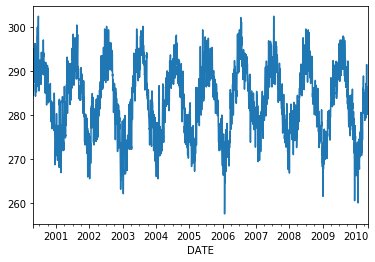

In [21]:
plot_df = df.loc['2000-04-25':'2010-05-15']
plot_df['TG'].plot()

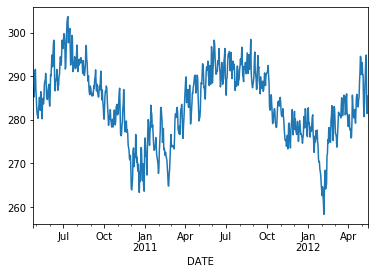

In [30]:
plot_df = df.loc['2010-04-25':'2012-05-15']
plot_df['TG'].plot()

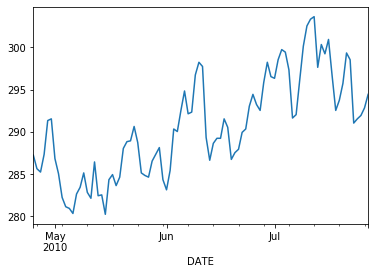

In [37]:
plot_df = df.loc['2010-04-25':'2010-07-27']
plot_df['TG'].plot()

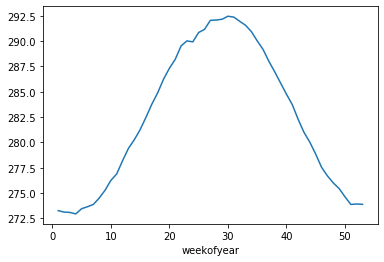

In [38]:
# groupby weekofyear
df['weekofyear'] = df.index.weekofyear
weekofyear_temp = df.groupby('weekofyear')['TG'].mean()
weekofyear_temp.plot() # SEASONALITY

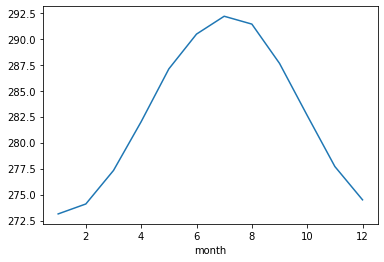

In [26]:
# groupby month
df['month'] = df.index.month
mm_temp = df.groupby('month')['TG'].mean()
mm_temp.plot() # SEASONALITY

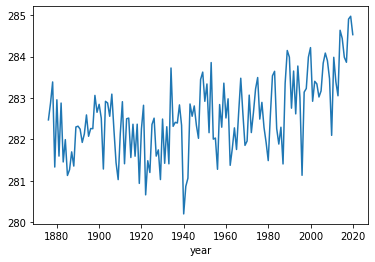

In [28]:
# groupby year
df['year'] = df.index.year
yearly_temp = df.groupby('year')['TG'].mean()
yearly_temp.plot() # TREND FROM THE 1970 VISIBLE

In [ ]:
the trend seems to be rather l